# Import Statements

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-12-04 04:56:27.570806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 04:56:27.570884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 04:56:27.572791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 04:56:27.584706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Dataset

In [27]:
import os
import cv2
import numpy as np
import pathlib

class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape

    def returnimagesaslist(self):
        self.images = []
        for label in self.labels:
            label_dir = os.path.join(self.datasetpath, label)
            image_files = list(pathlib.Path(label_dir).glob('*.[jJpP][pPnNgG]*'))
            self.images.append(image_files)

    def readImages(self):
        self.returnimagesaslist()
        self.finalImages = []
        labels = []

        for label_index in range(len(self.labels)):
            for img_path in self.images[label_index]:
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Skipping: {img_path}")
                    continue

                try:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0  # Normalize
                except Exception as e:
                    print(f"Error in {img_path}: {e}")
                    continue

                self.finalImages.append(img)
                labels.append(label_index)

        images = np.array(self.finalImages)
        labels = np.array(labels)

        print(f"Loaded {len(images)} images.")
        return images, labels


# ACGAN Architecture

In [3]:
class ACGAN:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
        
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
        
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        #ADDED NEXT LINE - Ablation
        # x = tf.image.resize(x, (75,75), method='bilinear')
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
        
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
        
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
        
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [4]:
ac_gan = ACGAN(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [5]:
generator, discriminator, GAN = ac_gan.build()

2025-12-04 04:56:31.025047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7507 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu[0][0]']         
                                                                                      

In [6]:
generator_loaded = tf.keras.models.load_model('generator_final.h5')

# VGG16 Architecture

In [7]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

In [8]:
model_fake = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
model_fake.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
model_fake.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [9]:
model_real = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
model_real.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
model_real.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

# Synthetic Dataset

## Generate Synthetic Dataset

In [10]:
datasetGenerationSize = 30000
# datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [11]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [12]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14984, 15016]))

In [13]:
synthetic_dataset = generator_loaded.predict([noize, newlabels])
synthetic_dataset.shape

2025-12-04 04:56:33.331928: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


938/938 [==============================] - 25s 25ms/step


(30000, 64, 64, 3)

In [14]:
#RESIZE IMAGE
# import tensorflow as tf

# # Resize generated images from 64x64 to 75x75
# imagesGeneration = tf.image.resize(
#     imagesGeneration, 
#     (75, 75)
# ).numpy()

# print(imagesGeneration.shape)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


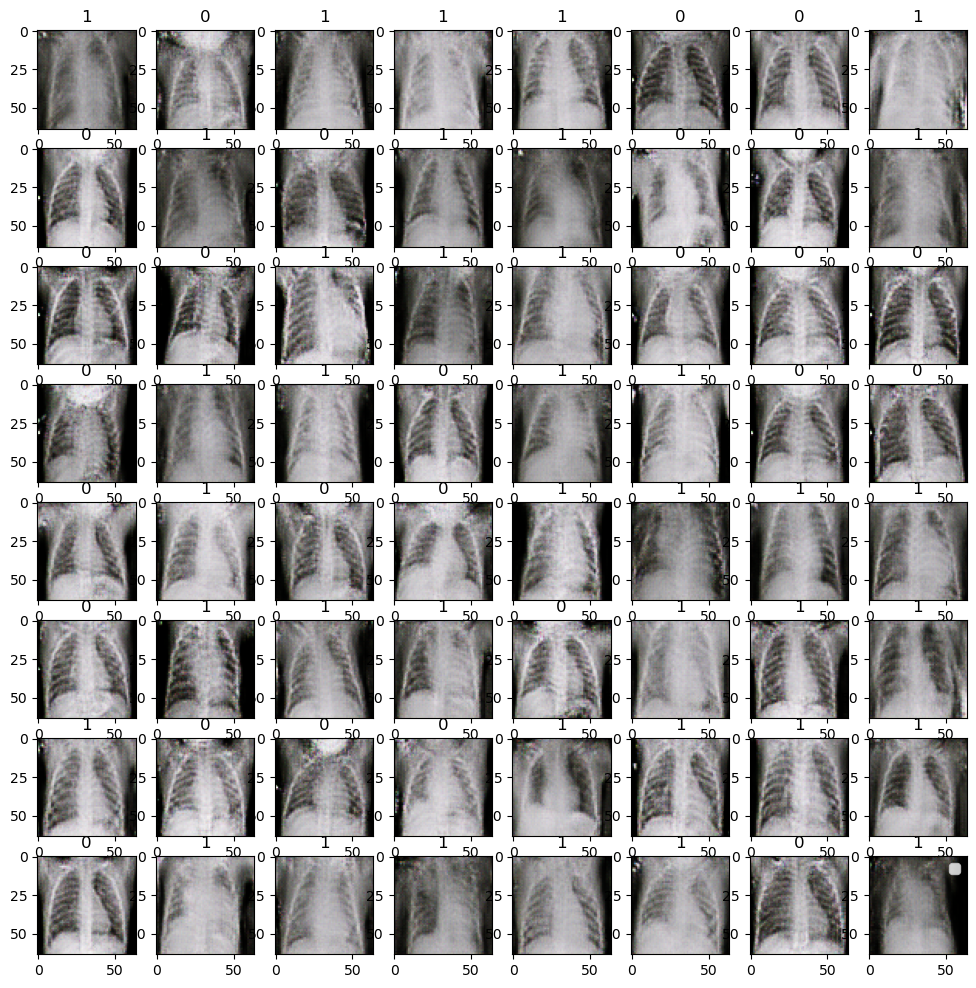

In [15]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(synthetic_dataset[i])
    plt.title(t[i])
plt.legend()

## Training

In [16]:
history = model_fake.fit(synthetic_dataset, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60


2025-12-04 04:57:13.618932: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc5f41f760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 04:57:13.618975: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-04 04:57:13.627833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764824233.763066 3345145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 40s 75ms/step - loss: 0.2585 - val_loss: 0.5590
Epoch 2/60
375/375 [==============================] - 26s 71ms/step - loss: 0.0831 - val_loss: 0.1115
Epoch 3/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0575 - val_loss: 0.0285
Epoch 4/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0484 - val_loss: 0.0238
Epoch 5/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0410 - val_loss: 0.0243
Epoch 6/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0380 - val_loss: 0.0178
Epoch 7/60
375/375 [==============================] - 27s 72ms/step - loss: 0.0330 - val_loss: 0.0172
Epoch 8/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0316 - val_loss: 0.0196
Epoch 9/60
375/375 [==============================] - 27s 71ms/step - loss: 0.0277 - val_loss: 0.0162
Epoch 10/60
375/375 [==============================] - 27s 72ms/step - loss: 0.0247 - val_los

## Results

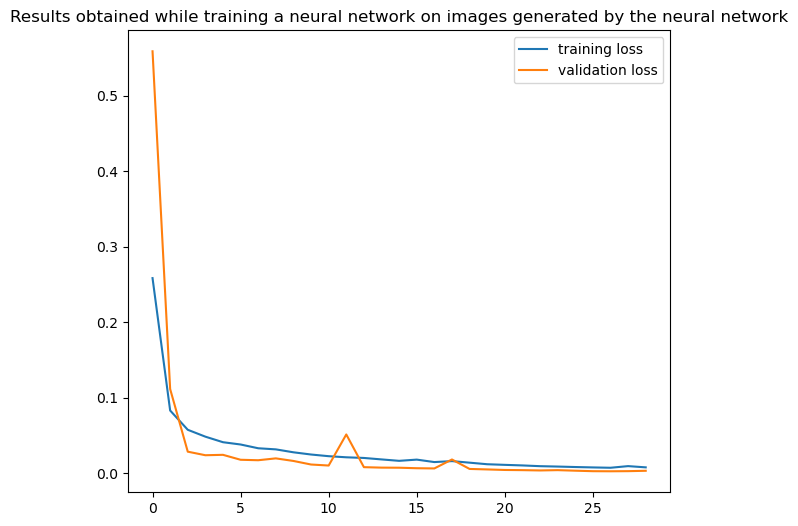

In [17]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [18]:
model_fake.save("vgg_model_fake.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model_fake = tf.keras.models.load_model("vgg_model_fake.h5")

## Test on Real Dataset

In [20]:
test_dataset = ReadDataset('chest_xray/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
X_test, y_test = test_dataset.readImages()

Loaded 624 images.


In [21]:
model_fake.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)


In [22]:
model_fake.evaluate(X_test, y_test)

20/20 [==============================] - 2s 48ms/step - loss: 0.4546 - accuracy: 0.8894


[0.4546433985233307, 0.8894230723381042]

In [23]:
y_pred = model_fake.predict(X_test)

y_pred = (y_pred >= 0.5).astype("int32")

y_pred = y_pred.reshape(-1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc * 100, "%")


20/20 [==============================] - 0s 11ms/step
Accuracy: 88.9423076923077 %


In [24]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       205
           1       0.95      0.88      0.91       419

    accuracy                           0.89       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.90      0.89      0.89       624



In [25]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, y_test)*100,
                                                                   recall_score(y_pred, y_test)*100,
                                                                   precision_score(y_pred, y_test)*100))

f1_score: 91.47095179233622, recall_score: 88.3054892601432, precision_score: 94.87179487179486


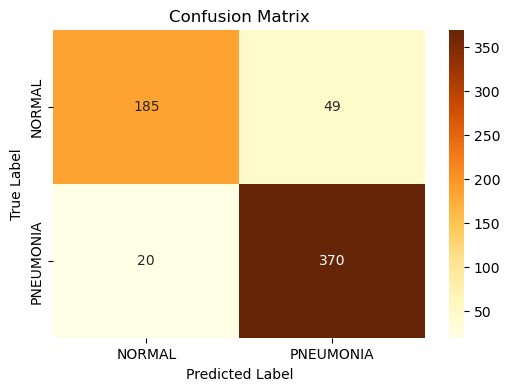

In [26]:
from sklearn.metrics import confusion_matrix

# Convert sigmoid -> class
y_pred_class = (y_pred >= 0.5).astype("int32").reshape(-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Create dataframe
cm_df = pd.DataFrame(
    cm,
    index=['NORMAL', 'PNEUMONIA'],
    columns=['NORMAL', 'PNEUMONIA']
)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
